In [7]:
import itk, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import tifffile as tif
import pandas as pd

# before this step, everything happens on the cluster
1. first Nishan takes the raw data and makes it into a dataset.h5 and dataset.xml file compatible with BigStitcher
2. we run CellMap_20240830.py on the dataset.h5 file. This is read, split into tiffs, and cm2 is run with these parameters below, which eventually creates "cells_filtered.npy"

```
  cell_detection_parameter = cells.default_cell_detection_parameter.copy();
  cell_detection_parameter['illumination_correction'] = None;
  cell_detection_parameter['background_correction']['shape'] = (12,12);
  cell_detection_parameter['intensity_detection']['measure'] = ['source'];
  cell_detection_parameter['shape_detection']['threshold'] = 100;
  
  io.delete_file(ws.filename('cells', postfix='maxima'))
  cell_detection_parameter['maxima_detection']['save'] = ws.filename('cells', p>
  sys.stdout.write('on processing param')
  processing_parameter = cells.default_cell_detection_processing_parameter.copy>
  processing_parameter.update(
      processes = 40, # 'serial',
      size_max = 100, #100, #35,
      size_min = 30, #30,
      overlap  = 15, #32, #10,
      verbose = True
      )
      
  thresholds = {
      'source' : 3,
      'size'   : (9,420)
      }

```

In [2]:
cells = np.load('../../../../2024-02-01/cells_filtered.npy')
np.shape(cells)

(12203987,)

In [5]:
print(np.max(cells['x']))
print(np.max(cells['y']))
print(np.max(cells['z']))

2047
2047
39650


In [6]:
df_cells = pd.DataFrame(cells[['x','y','z']])
np.max(df_cells.z)

39650

In [10]:
i=-1
for val in np.arange(0,40000,2000):
    #for 05-13 should be 1124 not 1999 (1125 multiples)
    i+=1
    sub_df=df_cells[(df_cells.z>=val)&(df_cells.z<val+2000)]
    sub_df.z=sub_df.z-(i*2000)
    print('on s{:02d}'.format(i),'len is ',len(sub_df))
    sub_df.to_csv('../../../../2024-02-01/s{:02d}_cells.csv'.format(i),header=False,index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


on s00 len is  656904
on s01 len is  1451126
on s02 len is  1304171
on s03 len is  538076
on s04 len is  338283
on s05 len is  794268
on s06 len is  771246
on s07 len is  426339
on s08 len is  624290
on s09 len is  685837
on s10 len is  649258
on s11 len is  493566
on s12 len is  394669
on s13 len is  626691
on s14 len is  564342
on s15 len is  341493
on s16 len is  16124
on s17 len is  725992
on s18 len is  775465
on s19 len is  25847


# then use big stitcher to run and come back to python

```
for i in {0..19}; 
do   (./transform-points --csvIn="../../2024-02-01/s${i}_cells.csv" --xml='../../2024-02-01/dataset.xml' -vi="0,${i}" --csvOut="../../2024-02-01/transformed_cells_${i}.txt" | tail -1); 
done
```
each volume space is originally in - to + coordinates that are somewhat random.
long term we should resave the xml such that the lowest point is 0,0,0
in the mean time I manually get the points

```
./transform-points -p=0,0,0 --xml='../../2024-02-01/dataset.xml' -vi="0,0"

```

which output

```
[-p=0,0,0, --xml=../../2024-02-01/dataset.xml, -vi=0,19]
xml: ../../2024-02-01/dataset.xml
Full bounding for acquisition: [-3348, -4153, -2150] -> [3361, 3984, 2052], dimensions (6710, 8138, 4203)
Using transformations of viewId: tpId=0 setupId=19
Applying 3d affine: 3d-affine: (0.9989147448484597, 0.0036842417426456364, -0.005586419932087294, -3336.382952430128, 0.009194227906874658, 0.9955467924508379, 0.003135422288656974, 1920.6325773574902, 0.012798322745635287, -0.003820968549952102, 2.0549030943040103, -2141.9206927840173)
-3336.382952430128,1920.6325773574902,-2141.9206927840173

```

In [51]:
# now cells are in volume space - each volume is a tile
# tile 0 is on the top right, tile 3 is the top left, tile 4 is second row far right...
# for 2024-02 each tile is 2048,2048,1999 and there are 19 tiles
    # the final downsampled tiff is axially sliced from the top of the brain to bottom, 
    # with cerebellum at the top of the image
    # 560x, 679y, 351z

for sval in np.arange(0,20):
    print(sval)
    data = pd.read_csv('../../../../2024-02-01/transformed_cells_{}.txt'.format(sval),header=None)
    data.columns=['x','y','z']
    # these below values are manually added based on the output from the transform_points call above & final volume size
    # this should be automated in the future
    xoff,yoff,zoff = [-3348, -4153, -2150]
    xmax,ymax,zmax=[6710, 8138, 4203]
    cmx,cmy,cmz=[560,679,351]

    data.x=((data.x-xoff)*(cmx/xmax)).astype(int)
    data.y=((data.y-yoff)*(cmy/ymax)).astype(int)
    data.z=((data.z-zoff)*(cmz/zmax)).astype(int)

    # now reformat these points for transformix
    df=pd.DataFrame([['point','',''],[str(len(data)),'','']],columns=['x','y','z'])
    df = pd.concat([df,data]).reset_index(drop=True)
    df.to_csv('/home/dennislab2/Desktop/2024-02-01/2024-02-01_points_s{}.txt'.format(sval),sep=' ',header=None,index=None)

    
# for 2024-05 each tile is 2048,2048,1124 and there are 19 tiles (4 columns, 5 rows)
    # same axial orientation as 2024-02
    # 512, 641, 356 dimensions


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
# transform points from downsampled to allen
# the function itself actually takes from the FIXED volume and puts in the MOVING volume,
# so we need to align the allen (moving) to the downsampled volume (fixed)
# one caveat: having a volume approximately 1.4x the size of the fixed is really nice, so we're
# going to do that, but have to divide everything by 1.4 at the end to get it into proper allen space
# ALSO I resliced Allen from sagittal to axial to match our volumes and avoid more axis swaps

fx = itk.imread('/home/dennislab2/Desktop/brains/2024-02-01_141816_fused_12.tif',pixel_type=itk.US)
mv = itk.imread('/home/dennislab2/Desktop/brains/allenCCF_25_resliced.tif')


# you only need to make the larger volume once, make this block 'code' to do so
reshape_vals=[]
for i in np.arange(0,3):
    mvshape = np.shape(mv)
    fxshape = np.shape(fx)
    reshape_vals.append((1.4*(fxshape[i]/mvshape[i])))
print(reshape_vals)
mv_140 = zoom(mv,reshape_vals,mode='nearest')

tif.imsave('../../../../allen_140.tif',mv_140)
print(np.shape(mv_140))

In [5]:
mv_140= itk.imread('../../../../allen_140.tif')

# if you haven't already, run alignment, takes about an hour BUT you only need to do this once! 
# turn this into a code block to run


# set the transforms
parameter_object = itk.ParameterObject.New()
parameter_object.AddParameterFile('/home/dennislab2/Desktop/GitHub/cleared_brains/parameter_folder/Order1_Par0000affine.txt')
parameter_object.AddParameterFile('/home/dennislab2/Desktop/GitHub/cleared_brains/parameter_folder/Order3_Par0000bspline.txt')
parameter_object.AddParameterFile('/home/dennislab2/Desktop/GitHub/cleared_brains/parameter_folder/Order4_Par0000bspline.txt')
parameter_object.AddParameterFile('/home/dennislab2/Desktop/GitHub/cleared_brains/parameter_folder/Order5_Par0000bspline.txt')

os.mkdir('/home/dennislab2/Desktop/allen_to_2024-02-01/')
result_img_elx, result_transform_params = itk.elastix_registration_method(fx,mv_140,parameter_object,log_to_file=True,output_directory='/home/dennislab2/Desktop/allen_to_2024-02-01')

In [9]:
# instead we load the param files from our elastix output folder
transform_to_apply=itk.elxParameterObjectPython.elastixParameterObject_New()
transform_to_apply.AddParameterFile('../../../../allen_to_2024-02-01/TransformParameters.0.txt')
transform_to_apply.AddParameterFile('../../../../allen_to_2024-02-01/TransformParameters.1.txt')
transform_to_apply.AddParameterFile('../../../../allen_to_2024-02-01/TransformParameters.2.txt')
transform_to_apply.AddParameterFile('../../../../allen_to_2024-02-01/TransformParameters.3.txt')


In [11]:
sval=1
transformed_coords=itk.transformix_pointset(mv_140,transform_to_apply,fixed_point_set_file_name='/home/dennislab2/Desktop/2024-02-01/2024-02-01_points_s{}.txt'.format(sval),output_directory="/home/dennislab2/Desktop")

In [14]:
dfx=pd.DataFrame(transformed_coords)
dfx.columns = dfx.columns.astype(str)
dfx = dfx[['46','47','48']]
dfx.columns=['x','y','z']
dfx.x=round(dfx.x.astype(int)/1.4).astype(int)
dfx.y=round(dfx.y.astype(int)/1.4).astype(int)
dfx.z=round(dfx.z.astype(int)/1.4).astype(int)

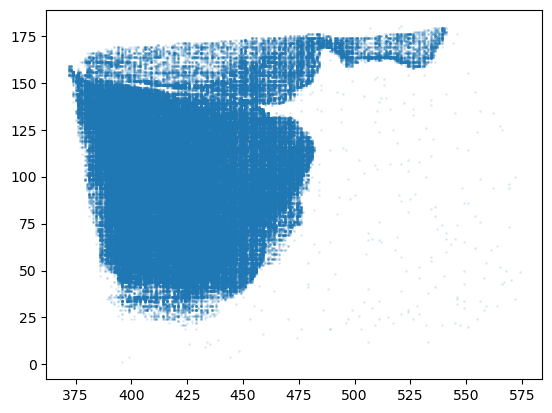

In [17]:
plt.scatter(dfx.x,dfx.y,s=1,alpha=.1)

(491, 951, 784)

In [22]:
cells=np.zeros(np.shape(mv_140))
for sval in np.arange(0,20):
    print(sval)
    transformed_coords=itk.transformix_pointset(mv_140,transform_to_apply,fixed_point_set_file_name='/home/dennislab2/Desktop/2024-02-01/2024-02-01_points_s{}.txt'.format(sval),output_directory="/home/dennislab2/Desktop/2024-02-01")
    dfx=pd.DataFrame(transformed_coords)
    dfx.columns = dfx.columns.astype(str)
    dfx = dfx[['46','47','48']]
    dfx.columns=['x','y','z']
    dfx.x=round(dfx.x.astype(int)/1.4).astype(int)
    dfx.y=round(dfx.y.astype(int)/1.4).astype(int)
    dfx.z=round(dfx.z.astype(int)/1.4).astype(int)
    dfx.to_csv('/home/dennislab2/Desktop/2024-02-01/points_{}.csv'.format(sval))
    for idx in dfx.index:
        x,y,z=[dfx.x[idx],dfx.y[idx],dfx.z[idx]]
        if (x<491) and (y<951) and (z<784):
            cells[x,y,z]+=1
    np.save('/home/dennislab2/Desktop/2024-02-01_cells_at{}.npy'.format(sval),cells)


0
1
2


KeyboardInterrupt: 